Part 3: Depth from Stereo:

Write a program to estimate a depth map from a pair of calibrated images in Figure 4 using an MRF and graphcuts. The camera matrices are available here. Note that, for finding the epipolar lines using the provided camera matrices, you might want to use the following equation:

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gco 
import numpy as np

image_l = cv2.imread('./non_rec_left.jpg',cv2.IMREAD_COLOR)
image_l = cv2.cvtColor(image_l, cv2.COLOR_BGR2RGB)
image_r = cv2.imread('./non_rec_right.jpg',cv2.IMREAD_COLOR)
image_r = cv2.cvtColor(image_r, cv2.COLOR_BGR2RGB)
print(image_l.shape)
# Define the text representation as a string
camera_data_1 = """
1221.2270770    0.0000000    479.5000000
0.0000000    1221.2270770    269.5000000
0.0000000    0.0000000    1.0000000
1.0000000000    0.0000000000    0.0000000000
0.0000000000    1.0000000000    0.0000000000
0.0000000000    0.0000000000    1.0000000000
0.0000000000    0.0000000000    0.0000000000
"""
lines = camera_data_1.strip().split('\n')
values = [line.split() for line in lines]
C1 = np.array([[float(val) for val in line] for line in values])


camera_data_2 = """
1221.2270770    0.0000000    479.5000000
0.0000000    1221.2270770    269.5000000
0.0000000    0.0000000    1.0000000
0.9998813487    0.0148994942    0.0039106989
-0.0148907594    0.9998865876    -0.0022532664
-0.0039438279    0.0021947658    0.9999898146
-9.9909793759    0.2451742154    0.1650832670
"""
lines_p = camera_data_2.strip().split('\n')
values_p = [line.split() for line in lines_p]
C2 = np.array([[float(val) for val in line] for line in values_p])
K_1,K_2=C1[0:3, :], C2[0:3, :]
R_1,R_2=C1[3:6, :], C2[3:6, :]
T_1,T_2=C1[6,:], C2[6,:]
T_1=T_1.reshape(3,1)
T_2=T_2.reshape(3,1)
print(T_1.shape, T_2.shape)

def get_edges_and_weights(image, m_lambda, disparity):
    h, w, d = image.shape
    # h, w= 10, 10
    E = (h - 1) * w + h * (w - 1)
    edges = np.empty((E, 2), dtype=np.int32)
    edge_weights = np.ones(E, dtype=np.float)
    for i in range(len(edge_weights)):
        edge_weights[i]=5
    idx = 0
    for row in range(h):
        edges[idx:idx+w-1,0] = np.arange(w-1) + row * w
        edges[idx:idx+w-1,1] = np.arange(w-1) + row * w + 1
        idx += w-1

    # vertical edges
    for col in range(w):
        edges[idx:idx+h-1,0] = np.arange(0, (h-1)*w, w) + col
        edges[idx:idx+h-1,1] = np.arange(w, h*w, w) + col
        idx += h-1
    return [edges, edge_weights]

(540, 960, 3)
(3, 1) (3, 1)


In [2]:
def measure_depth(left_image,right_image,disparity,dis_max, m_lambda): # disparity max=0.1
    d=np.linspace(0,dis_max,disparity)
    smooth=1-np.eye(disparity)
    H, W, _= left_image.shape
    fp = np.zeros([disparity,disparity])
    for d_x, x in enumerate(d) :
        for d_y, y in enumerate(d):
            fp[d_x,d_y] = abs(x-y)
                
    h_l, w_l,_= left_image.shape
    Mk_f=np.zeros([h_l*w_l,disparity])
    for row in range (h_l):
        for col in range (w_l):
            for index, dis in  enumerate(d):
                x_h=np.array([[col],[row],[1]])
                x_hp_1 = np.dot(K_2,(R_2).T)
                x_hp_2 = np.dot(x_hp_1,R_1)
                x_hp_3 = np.dot(x_hp_2,np.linalg.inv(K_1))
                x_hp=np.dot(x_hp_3,x_h)
               #  print(x_hp)
                x_hp_4 = dis*(np.dot(K_2,(R_2).T))
                temp = T_1-T_2
                x_hp = x_hp + np.dot(x_hp_4,temp)
                x_hp=np.round(x_hp/x_hp[2])
               #  print(x_hp.shape)
                d_y, d_x= int(x_hp[0]), int(x_hp[1])
                if d_x>=H:
                   d_x=H-1
                if d_x<0:
                   d_x=0
                if d_y>=W:
                   d_y=W-1
                if d_y<0:
                   d_y=0
                Mk_f[row*w_l+col][index]=np.sum(abs(image_l[row][col]-image_r[int(d_x)][int(d_y)]))/3
               
                
    edges, edge_weights=get_edges_and_weights(left_image, m_lambda , disparity)
   #  print(edges, edge_weights)
    labels = gco.cut_general_graph(edges, edge_weights*m_lambda, Mk_f, fp*m_lambda, n_iter=-1,algorithm='swap')
    # labels=gco.cut_grid_graph_simple(Mk_f, smooth*0.5, n_iter=-1)
    labels = labels.reshape(h_l,w_l)    
    plt.imshow(labels,'gray')
    
    
   

Disparity max = 1

/tmp/ipykernel_995/1924143961.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_y, d_x= int(x_hp[0]), int(x_hp[1])


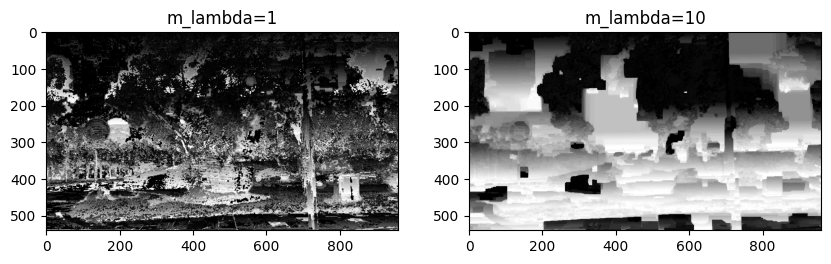

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.title('m_lambda=1')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=1,m_lambda=1)
plt.subplot(322)
plt.title('m_lambda=10')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=1,m_lambda=10)



Disparity max = 0.1

/tmp/ipykernel_995/1924143961.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_y, d_x= int(x_hp[0]), int(x_hp[1])


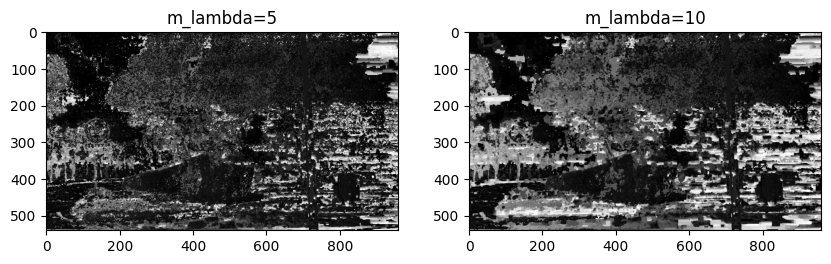

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.title('m_lambda=5')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=0.1,m_lambda=5)
plt.subplot(322)
plt.title('m_lambda=10')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=0.1,m_lambda=10)


Disparity_max=0.01

/tmp/ipykernel_995/1924143961.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_y, d_x= int(x_hp[0]), int(x_hp[1])


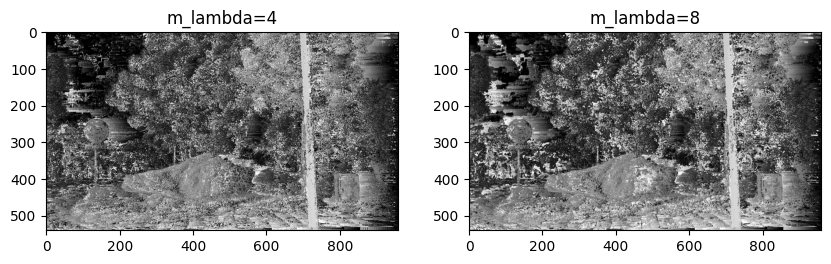

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.title('m_lambda=4')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=0.01,m_lambda=4)
plt.subplot(322)
plt.title('m_lambda=8')
measure_depth(left_image=image_l, right_image=image_r,disparity=50,dis_max=0.01,m_lambda=8)

/tmp/ipykernel_60906/1924143961.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_y, d_x= int(x_hp[0]), int(x_hp[1])


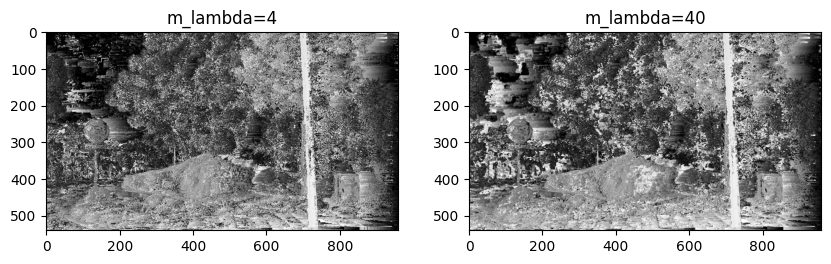

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.title('m_lambda=4')
measure_depth(left_image=image_l, right_image=image_r,disparity=60,dis_max=0.009,m_lambda=4)
plt.subplot(322)
plt.title('m_lambda=40')
measure_depth(left_image=image_l, right_image=image_r,disparity=60,dis_max=0.009,m_lambda=10)

Show your best result, and provide some discussion if necessary (particularly if the results are not as good as expected).

Discussion: 

The result of the depth figure demonstrates the noise and ambiguity of specific details. As m_lambda increases, more noise pixels will be denoised, however, it will also lead to the loss of edges and details of trees and stones that are in the middle depth of the image. Lager m_lambda values will lead to the wrong calculation of the depth value. In order to obtain a better result, m_lambda should depend on x instead of being a uniform value.

Secondly, the choice of disparity also affects the result of the image. As the maxiumn of disparity increase, the pixel from the left image will obtain a higher possibility of finding the pixel at the right image but not the authentic point in the real world, consequently, reducing the accuracy of the overall reuslt (failure of the experiment).

Thirdly, the quality of depth prediction may be optimized if the edge_weights= m_lambda is not uniform. However, it haven't been testified so far.

As a result, the best reuslt among Part_3 is achieved when using abs in calculation disparity_max=0.009, m_lambda= 4

/tmp/ipykernel_50138/1773512803.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_y, d_x= int(x_hp[0]), int(x_hp[1])


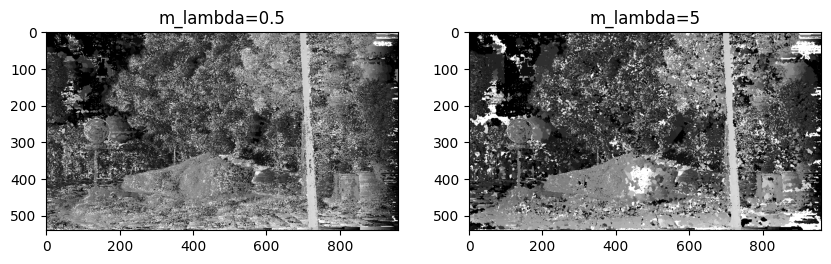

In [5]:
def measure_depth_surrounding(left_image,right_image,disparity,dis_max, m_lambda): # disparity max=0.1
    d=np.linspace(0,dis_max,disparity)
    smooth=1-np.eye(disparity)
    H, W, _= left_image.shape
    fp = np.zeros([disparity,disparity])
    for d_x, x in enumerate(d) :
        for d_y, y in enumerate(d):
            fp[d_x,d_y] = abs(x-y)
                
    h_l, w_l,_= left_image.shape
    Mk_f=np.zeros([h_l,w_l,disparity])
    for row in range (h_l):
        for col in range (w_l):
            for index, dis in  enumerate(d):
                x_h=np.array([[col],[row],[1]])
                x_hp_1 = np.dot(K_2,(R_2).T)
                x_hp_2 = np.dot(x_hp_1,R_1)
                x_hp_3 = np.dot(x_hp_2,np.linalg.inv(K_1))
                x_hp=np.dot(x_hp_3,x_h)
                x_hp_4 = dis*(np.dot(K_2,(R_2).T))
                temp = T_1-T_2
                x_hp = x_hp + np.dot(x_hp_4,temp)
                x_hp=np.round(x_hp/x_hp[2])
                d_y, d_x= int(x_hp[0]), int(x_hp[1])
                if d_x>=H:
                   d_x=H-1
                if d_x<0:
                   d_x=0
                if d_y>=W:
                   d_y=W-1
                if d_y<0:
                   d_y=0
                Mk_f[row][col][index]=np.sum(abs(image_l[row][col]-image_r[int(d_x)][int(d_y)]))/3
               
    labels=gco.cut_grid_graph_simple(Mk_f, smooth*m_lambda, connect=8, n_iter=-1,algorithm= 'swap')
    labels = labels.reshape(h_l,w_l)    
    plt.imshow(labels,'gray')
    
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.title('m_lambda=0.5')
measure_depth_surrounding(left_image=image_l, right_image=image_r,disparity=60,dis_max=0.01,m_lambda=0.5)
plt.subplot(322)
plt.title('m_lambda=5')
measure_depth_surrounding(left_image=image_l, right_image=image_r,disparity=60,dis_max=0.01,m_lambda=5)
   

/tmp/ipykernel_50138/1773512803.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d_y, d_x= int(x_hp[0]), int(x_hp[1])


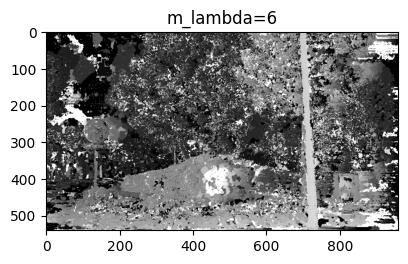

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.title('m_lambda=6')
measure_depth_surrounding(left_image=image_l, right_image=image_r,disparity=60,dis_max=0.01,m_lambda=6)

Further Discussion: In order to achieve higher quality of the depth image, contrary to previous edge weight that only include the upper and right pixel, the new function of simple_graph_cuts take the surrounding pixels into consideration. As the optimized result shown below, this more complicated graph cut configuration is condusive to image denoising by improving the consistancy of pixels with their surroudings. The best depth image is botained when m_lambda = 6, while it has the drawback of losing detailed information.